# The Entirety of Code (with the Thought Process!)

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 

In [5]:
import nnfs
from nnfs.datasets import spiral_data
nnfs.init()

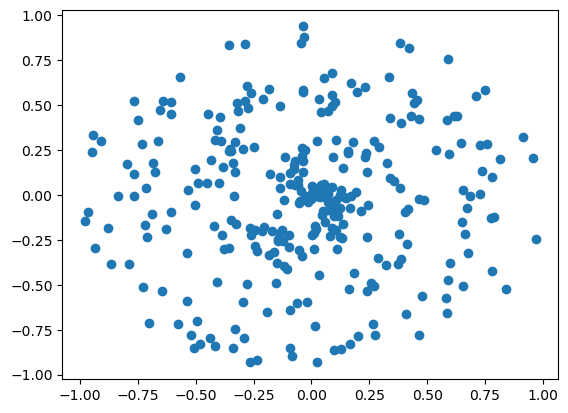

In [7]:
X, y = spiral_data(samples=100, classes=3)
plt.scatter(X[:, 0], X[:, 1])
plt.show()

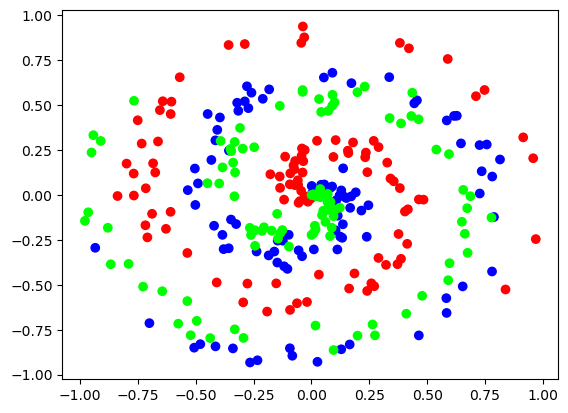

In [11]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='brg')
plt.show()

In [151]:
X[:5]

array([[0.        , 0.        ],
       [0.00299556, 0.00964661],
       [0.01288097, 0.01556285],
       [0.02997479, 0.0044481 ],
       [0.03931246, 0.00932828]], dtype=float32)

## AIM: build the neural network than can classify spiral data above

## Layer Class for a Layer of Neurons

In [608]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons, weight_regularizer_l1=0, weight_regularizer_l2=0, bias_regularizer_l1=0, bias_regularizer_l2=0):
        self.weights = np.random.randn(n_inputs, n_neurons)    # weights in columns
        self.biases = np.zeros((1, n_neurons))    # 0s work for spiral data
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    # forward pass of data from this layer
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    # backward pass (backpropagation)
    # dvalues = dL_dz
    def backward(self, dvalues): 
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True) 
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)

        if(self.weight_regularizer_l1 > 0):
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1

        if(self.weight_regularizer_l2 > 0):
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights

        if(self.bias_regularizer_l1 > 0):
            dL2 = np.ones_like(self.biases)
            dL2[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l2 * dL2

        if(self.bias_regularizer_l2 > 0):
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases

## Activation Functions

In [246]:
class Activation_ReLU:
    # forward pass
    def forward(self, inputs): 
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    # backward pass 
    # dvalues = dL_da
    def backward(self, dvalues): 
        # make a copy of dvalues
        self.dinputs = dvalues.copy() 
        # zero gradient where input values were negative
        # dinputs = dL_dz (z is the input to the activation, hence dinputs)
        self.dinputs[self.inputs <= 0] = 0

In [248]:
class Activation_Softmax:
    def forward(self, inputs): 
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities

### One Forward Pass

In [166]:
# One Forward Pass (without loss function)
dense1 = Layer_Dense(2, 3)
dense2 = Layer_Dense(3, 3)

activation1 = Activation_ReLU() 
activation2 = Activation_Softmax()

dense1.forward(X)
activation1.forward(dense1.output)

dense2.forward(activation1.output)
activation2.forward(dense2.output)

activation2.output[:5]

array([[0.33333334, 0.33333334, 0.33333334],
       [0.33173057, 0.3318284 , 0.336441  ],
       [0.3288542 , 0.3291243 , 0.3420215 ],
       [0.32587105, 0.32631534, 0.34781358],
       [0.32318372, 0.32378128, 0.35303497]], dtype=float32)

## Loss Functions

In [576]:
class Loss:
    def calculate(self, output, y): 
        # loss for each sample (array)
        sample_losses = self.forward(output, y) 
        # average loss of all samples
        data_loss = np.mean(sample_losses)
        return data_loss

    def regularization_loss(self, layer):
        regularization_loss = 0
        if(layer.weight_regularizer_l1 > 0):
            regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))
        if(layer.weight_regularizer_l2 > 0):
            regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights ** 2)
        if(layer.bias_regularizer_l1 > 0):
            regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))
        if(layer.bias_regularizer_l2 > 0):
            regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases ** 2)
        return regularization_loss
        

In [578]:
class Loss_CategoricalCrossEntropy(Loss): 
    def forward(self, y_pred, y_true): 
        # no of samples in a batch 
        samples = len(y_pred)
        # clip predictions to avoid 0s and 1s
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        # class targets are 1 dimensional 
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(len(y_pred_clipped)),
                y_true
            ]
        # class targets are one hot encoded
        elif len(y_true.shape) == 2: 
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)
        # losses 
        neg_log_likelihoods = -np.log(correct_confidences)
        return neg_log_likelihoods

    # dvalues = y_pred (softmax outputs)
    def backward(self, dvalues, y_true):
        # number of samples
        samples = len(dvalues) 
        # number of labels/inputs
        labels = len(dvalues[0])
        # one-hot-encode y_true if sparse
        if(len(y_true.shape) == 1):
            y_true = np.eye(labels)[y_true]
        # calculate gradient
        self.dinputs = -y_true / dvalues
        # normalize gradient
        self.dinputs = self.dinputs / samples

### softmax classifier - combined softmax activation and cross-entropy loss for faster backward step

In [580]:
class Activation_Softmax_Loss_CategoricalCrossEntropy:
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossEntropy()

    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output 
        return self.loss.calculate(self.output, y_true)

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        # convert if one-hot-encoded
        if(len(y_true.shape) == 2): 
            y_true = np.argmax(y_true, axis=1)
        self.dinputs = dvalues.copy()
        # gradient = y_pred - y_true
        self.dinputs[range(samples), y_true] -= 1
        # normalize gradient
        self.dinputs = self.dinputs / samples

In [582]:
# calculate accuracy
def calculate_accuracy(output, class_targets):
    # get the indices of max probabilities
    predictions = np.argmax(output, axis=1)
    # convert class_targets if one-hot-encoded
    if class_targets.shape == 2:
        class_targets = np.argmax(class_targets, axis=1)
        
    accuracy = np.mean(predictions == class_targets)
    return accuracy
    

### Calculating Loss & Accuracy for One Forward Pass

In [180]:
# forward pass (with loss) 
dense1 = Layer_Dense(2, 3)
dense2 = Layer_Dense(3, 3)

activation1 = Activation_ReLU() 
activation2 = Activation_Softmax()

dense1.forward(X)
activation1.forward(dense1.output)

dense2.forward(activation1.output)
activation2.forward(dense2.output)

print(activation2.output[:5])

loss_function = Loss_CategoricalCrossEntropy()
loss = loss_function.calculate(activation2.output, y)
print("loss:", loss)

acc = calculate_accuracy(activation2.output, y)
print("accuracy:", acc)

[[0.33333334 0.33333334 0.33333334]
 [0.33333334 0.33333334 0.33333334]
 [0.3333046  0.3333975  0.33329794]
 [0.33304664 0.333973   0.3329804 ]
 [0.33298147 0.3341184  0.33290014]]
loss: 1.1034379
accuracy: 0.29333333333333333


## Optimizations

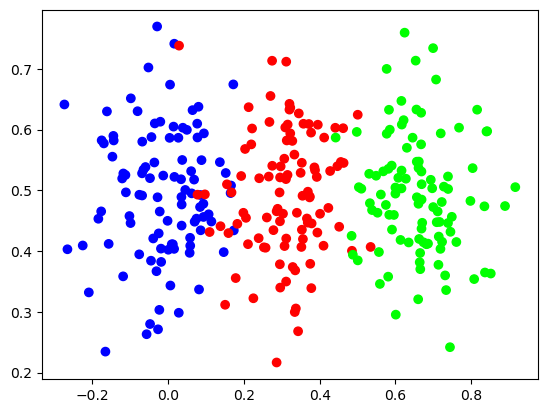

In [46]:
from nnfs.datasets import vertical_data
X_temp, y_temp = vertical_data(samples=100, classes=3)
plt.scatter(X_temp[:, 0], X_temp[:, 1], c=y_temp, cmap='brg') 
plt.show()

### Strategy 1: Randomly SELECT Weights and Biases (ass technique, doesn't work!)

randomly select the weights and biases each time
if loss decreases, find the next best weights and biases

In [51]:
dense1_temp = Layer_Dense(2, 3)
dense2_temp = Layer_Dense(3, 3)

Activation1_temp = Activation_ReLU()
Activation2_temp = Activation_Softmax()

loss_function = Loss_CategoricalCrossEntropy()

# helper vars 
lowest_loss = 999999 #random value to start with
best_dense1_temp_weights = dense1_temp.weights.copy()
best_dense1_temp_biases = dense1_temp.biases.copy()
best_dense2_temp_weights = dense2_temp.weights.copy()
best_dense2_temp_biases = dense2_temp.biases.copy() 

# iterate 100000 times to get the minimum loss weights
for i in range(100000):
    # generate new sets of weights 
    dense1_temp.weights = 0.05 * np.random.randn(2, 3)
    dense1_temp.biases = 0.05 * np.random.randn(1, 3)
    dense2_temp.weights = 0.05 * np.random.randn(3, 3)
    dense2_temp.biases = 0.05 * np.random.randn(1, 3)

    # pass the data ahead
    dense1_temp.forward(X_temp)
    Activation1_temp.forward(dense1_temp.output)

    dense2_temp.forward(Activation1_temp.output)
    Activation2_temp.forward(dense2_temp.output)

    current_loss = loss_function.calculate(Activation2_temp.output, y_temp) 

    if current_loss < lowest_loss: 
        lowest_loss = current_loss
        best_dense1_temp_weights = dense1_temp.weights.copy()
        best_dense1_temp_biases = dense1_temp.biases.copy()
        best_dense2_temp_weights = dense2_temp.weights.copy()
        best_dense2_temp_biases = dense2_temp.biases.copy()

        acc = round(calculate_accuracy(Activation2_temp.output, y), 2)
        print("new best loss found:", lowest_loss, "with accuracy:", acc, "at iteration:", i)


new best loss found: 1.0989256 with accuracy: 0.33 at iteration: 0
new best loss found: 1.0985119 with accuracy: 0.33 at iteration: 1
new best loss found: 1.0984937 with accuracy: 0.33 at iteration: 30
new best loss found: 1.0981877 with accuracy: 0.33 at iteration: 58
new best loss found: 1.0980561 with accuracy: 0.33 at iteration: 180
new best loss found: 1.0977279 with accuracy: 0.33 at iteration: 199
new best loss found: 1.0976243 with accuracy: 0.33 at iteration: 254
new best loss found: 1.0975127 with accuracy: 0.33 at iteration: 343
new best loss found: 1.0968096 with accuracy: 0.35 at iteration: 446
new best loss found: 1.0960783 with accuracy: 0.33 at iteration: 467
new best loss found: 1.0955629 with accuracy: 0.33 at iteration: 12861
new best loss found: 1.0954995 with accuracy: 0.33 at iteration: 75613
new best loss found: 1.0950661 with accuracy: 0.35 at iteration: 78653


### Strategy 2: Randomly ADJUST Weights and Biases (works! but still not good)

find the weights and biases in close proximity to the current weights and biases and calculate the loss
if loss is less, update the weights and then find the next best weights and biases w.r.t the new weights and biases 

In [55]:
dense1_temp = Layer_Dense(2, 3)
dense2_temp = Layer_Dense(3, 3)

Activation1_temp = Activation_ReLU()
Activation2_temp = Activation_Softmax()

loss_function = Loss_CategoricalCrossEntropy()

# helper vars 
lowest_loss = 999999 #random value to start with
best_dense1_temp_weights = dense1_temp.weights.copy()
best_dense1_temp_biases = dense1_temp.biases.copy()
best_dense2_temp_weights = dense2_temp.weights.copy()
best_dense2_temp_biases = dense2_temp.biases.copy() 

# iterate 100000 times to get the minimum loss weights
for i in range(10000):
    # update weights with small random values
    dense1_temp.weights += 0.05 * np.random.randn(2, 3)
    dense1_temp.biases += 0.05 * np.random.randn(1, 3)
    dense2_temp.weights += 0.05 * np.random.randn(3, 3)
    dense2_temp.biases += 0.05 * np.random.randn(1, 3)

    # pass the data ahead
    dense1_temp.forward(X_temp)
    Activation1_temp.forward(dense1_temp.output)

    dense2_temp.forward(Activation1_temp.output)
    Activation2_temp.forward(dense2_temp.output)

    current_loss = loss_function.calculate(Activation2_temp.output, y_temp) 

    if current_loss < lowest_loss: 
        lowest_loss = current_loss
        best_dense1_temp_weights = dense1_temp.weights.copy()
        best_dense1_temp_biases = dense1_temp.biases.copy()
        best_dense2_temp_weights = dense2_temp.weights.copy()
        best_dense2_temp_biases = dense2_temp.biases.copy()

        acc = round(calculate_accuracy(Activation2_temp.output, y), 2)
        print("new best loss found:", lowest_loss, "with accuracy:", acc, "at iteration:", i)

    else:
        dense1_temp.weights = best_dense1_temp_weights.copy()
        dense1_temp.biases = best_dense1_temp_biases.copy()
        dense2_temp.weights = best_dense2_temp_weights.copy()
        dense2_temp.biases = best_dense2_temp_biases.copy()
        

new best loss found: 1.0639795 with accuracy: 0.36 at iteration: 0
new best loss found: 1.0545703 with accuracy: 0.33 at iteration: 1
new best loss found: 1.0445948 with accuracy: 0.33 at iteration: 6
new best loss found: 1.0377543 with accuracy: 0.33 at iteration: 8
new best loss found: 1.0354288 with accuracy: 0.34 at iteration: 9
new best loss found: 1.0288478 with accuracy: 0.48 at iteration: 10
new best loss found: 1.0201641 with accuracy: 0.42 at iteration: 12
new best loss found: 1.0057148 with accuracy: 0.37 at iteration: 14
new best loss found: 1.0021744 with accuracy: 0.37 at iteration: 17
new best loss found: 1.000106 with accuracy: 0.36 at iteration: 24
new best loss found: 0.9985317 with accuracy: 0.4 at iteration: 25
new best loss found: 0.9934555 with accuracy: 0.4 at iteration: 28
new best loss found: 0.98727256 with accuracy: 0.43 at iteration: 29
new best loss found: 0.9771681 with accuracy: 0.67 at iteration: 31
new best loss found: 0.9598429 with accuracy: 0.61 at i

### Strat 2 gives ~95% accuracy with ~0.1 loss, let's try the same method for Complex Data

In [58]:
#randomly adjust weights and biases in the close proximity and find the best weights and biases

dense1_temp = Layer_Dense(2, 3)
dense2_temp = Layer_Dense(3, 3)

Activation1_temp = Activation_ReLU()
Activation2_temp = Activation_Softmax()

loss_function = Loss_CategoricalCrossEntropy()

# helper vars 
lowest_loss = 999999 #random value to start with
best_dense1_temp_weights = dense1_temp.weights.copy()
best_dense1_temp_biases = dense1_temp.biases.copy()
best_dense2_temp_weights = dense2_temp.weights.copy()
best_dense2_temp_biases = dense2_temp.biases.copy() 

# iterate 100000 times to get the minimum loss weights
for i in range(10000):
    # update weights with small random values
    dense1_temp.weights += 0.05 * np.random.randn(2, 3)
    dense1_temp.biases += 0.05 * np.random.randn(1, 3)
    dense2_temp.weights += 0.05 * np.random.randn(3, 3)
    dense2_temp.biases += 0.05 * np.random.randn(1, 3)

    # pass the data ahead
    dense1_temp.forward(X)
    Activation1_temp.forward(dense1_temp.output)

    dense2_temp.forward(Activation1_temp.output)
    Activation2_temp.forward(dense2_temp.output)

    current_loss = loss_function.calculate(Activation2_temp.output, y) 

    if current_loss < lowest_loss: 
        lowest_loss = current_loss
        best_dense1_temp_weights = dense1_temp.weights.copy()
        best_dense1_temp_biases = dense1_temp.biases.copy()
        best_dense2_temp_weights = dense2_temp.weights.copy()
        best_dense2_temp_biases = dense2_temp.biases.copy()

        acc = round(calculate_accuracy(Activation2_temp.output, y), 2)
        print("new best loss found:", lowest_loss, "with accuracy:", acc, "at iteration:", i)

    else:
        dense1_temp.weights = best_dense1_temp_weights.copy()
        dense1_temp.biases = best_dense1_temp_biases.copy()
        dense2_temp.weights = best_dense2_temp_weights.copy()
        dense2_temp.biases = best_dense2_temp_biases.copy()
        

new best loss found: 1.1240796 with accuracy: 0.33 at iteration: 0
new best loss found: 1.1231076 with accuracy: 0.27 at iteration: 2
new best loss found: 1.1208069 with accuracy: 0.32 at iteration: 3
new best loss found: 1.1156522 with accuracy: 0.31 at iteration: 5
new best loss found: 1.1135806 with accuracy: 0.33 at iteration: 8
new best loss found: 1.1097816 with accuracy: 0.32 at iteration: 10
new best loss found: 1.1097435 with accuracy: 0.32 at iteration: 16
new best loss found: 1.1087543 with accuracy: 0.32 at iteration: 17
new best loss found: 1.1087471 with accuracy: 0.32 at iteration: 19
new best loss found: 1.1062927 with accuracy: 0.31 at iteration: 24
new best loss found: 1.1059976 with accuracy: 0.32 at iteration: 30
new best loss found: 1.1041901 with accuracy: 0.3 at iteration: 32
new best loss found: 1.102151 with accuracy: 0.32 at iteration: 43
new best loss found: 1.1017482 with accuracy: 0.32 at iteration: 55
new best loss found: 1.1008308 with accuracy: 0.33 at i

<h3 style="color: red; font-weight: semibold;">Whoops! the new method fails!</h3>

## Backpropagation 
### Gradient Descent 
## $ W = W - \alpha \frac{d}{dW}L$
## $ W := W - \alpha \nabla_WL $

### Backpropagation on a single neuron


In [65]:
inputs = np.array([-2, 5, -1])
weights = np.array([1.0, 3.0, -2.0])
bias = 3

target_output = 3.14159
alpha = 0.001

### Optimizing the Loss for weights $ W_0, W_1, W_2, b $ 
### Gradients -> { $ \frac{\partial}{\partial W_0}L, \frac{\partial}{\partial W_1}L, \frac{\partial}{\partial W_2}L, \frac{\partial}{\partial b}L,  $ }
### New Weights and Bias -> $ W_i - \alpha \frac{\partial}{\partial W_i}L, b - \alpha \frac{\partial}{\partial b}L $

In [67]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0.0, 1.0, 0.0)

for i in range(200):
    # forward pass
    linear_output = np.dot(inputs, weights.T) + bias
    output = relu(linear_output)
    loss = (output - target_output) ** 2

    print("output: ", output, "loss: ", loss)

    # backward pass
    dloss_doutput = 2 * (output - target_output)
    doutput_dlinear = relu_derivative(dloss_doutput)
    dlinear_dweights = inputs
    dlinear_dbias = 1.0

    dloss_dlinear = dloss_doutput * doutput_dlinear
    dloss_dweights = dloss_dlinear * dlinear_dweights
    dloss_dbias = dloss_dlinear * dlinear_dbias

    # update weights and biases
    weights -= alpha * dloss_dweights
    bias -= alpha * dloss_dbias

final_output = relu(np.dot(inputs, weights.T) + bias)
print("\nfinal output:", final_output)
print("final loss:", final_output**2)

print("\nfinal weights:", weights)
print("final bias:", bias)

output:  18.0 loss:  220.7723477281
output:  17.078778892280273 loss:  194.24523421910058
output:  16.21467328280626 loss:  170.90550651918846
output:  15.404141435088302 loss:  150.37016769818615
output:  14.64386327283092 loss:  132.30229044288052
output:  13.930722770474711 loss:  116.40538593893133
output:  13.261796101003098 loss:  102.41857152678034
output:  12.6343436221507 loss:  90.11237133085525
output:  12.045793295570462 loss:  79.28483632884786
output:  11.493731768556957 loss:  69.75827212207375
output:  10.975899288303534 loss:  61.37640202479903
output:  10.490172228564818 loss:  54.00166076997867
output:  10.034559956380638 loss:  47.5130348195661
output:  9.607195983020612 loss:  41.80406072767193
output:  9.206328655789678 loss:  36.78105496302959
output:  8.83031472947297 loss:  32.361589047717324
output:  8.47761390431212 loss:  28.473151107390365
output:  8.146780037045488 loss:  25.051927306939415
output:  7.836458568409386 loss:  22.041790874638394
output:  7.54

### Backpropagation on a layer of neurons

In [71]:
inputs = np.array([1, 2, 3, 4])
weights = np.array([
    [0.1, 0.2, 0.4, 0.61], 
    [0.3, 0.8, 0.7, 0.22], 
    [1.1, 2.1, 3.2, 0.36],
])
biases = np.array([4, 2, 0.4])

target = 3.14159
alpha = 0.001

In [72]:
# relu and it's derivative function remains the same

for i in range(200): 
    z = np.dot(inputs, weights.T) + biases 
    a = relu(z) 
    y = np.sum(a) 
    
    loss = (y - target) ** 2
    
    # Gradient of loss w.r.t output y
    dL_dy = 2 * (y - target) 
    # Gradient of y w.r.t a
    dy_da = np.ones_like(a)
    # Gradient of loss wrt a
    dL_da = dL_dy * dy_da
    # Gradient of a w.r.t z
    da_dz = relu_derivative(z)
    # Gradient of loss w.r.t z
    dL_dz = dL_da * da_dz
    
    # Gradient of loss w.r.t to weights and biases
    dL_dW = np.outer(dL_dz, inputs)    # as dz_dW = inputs
    dL_db = dL_dz * 1    # as dz_db = 1

    weights -= alpha * dL_dW 
    biases -= alpha * dL_db

    if(i % 20 == 0):
        print("output:", y)
        print("loss:", loss)
        print()

print("final weights: \n", weights)
print("final biases: \n", biases)

output: 31.760000133514403
loss: 819.0133985700398

output: 5.852548607715017
loss: 7.349296572744142

output: 3.895257294346993
loss: 0.5680143905683172

output: 3.3511151721793313
loss: 0.04390079777677848

output: 3.1998396293369615
loss: 0.0033930193178934235

output: 3.1577837477913047
loss: 0.0002622374675283884

output: 3.1460919610087346
loss: 2.0267652924167363e-05

output: 3.142841652183635
loss: 1.566633188798234e-06

output: 3.1419379835955517
loss: 1.2109258277313835e-07

output: 3.1416866929640435
loss: 9.349529295532382e-09

final weights: 
 [[-0.17280176 -0.34560352 -0.41840528 -0.48120704]
 [ 0.06514258  0.33028516 -0.00457225 -0.71942967]
 [ 0.66134248  1.22268496  1.88402744 -1.39463008]]
final biases: 
 [ 3.72719824  1.76514258 -0.03865752]


## Backprop with matrices 

### gradient of Loss wrt Weights 
### $ X^T.\frac{\partial L}{\partial z} $ 

In [76]:
# dLdz matrix
dvalues = np.array([
    [1, 1, 1],
    [2, 2, 2],
    [3, 3, 3]
], dtype='float')

# 3 sets of inputs - samples
inputs = np.array([
    [1, 2, 3, 2.5],
    [2, 5, -1, 2], 
    [-1.5, 2.7, 3.3, -0.8]
])

# dLdW
dweights = np.dot(inputs.T, dvalues)
print(dweights)

[[ 0.5  0.5  0.5]
 [20.1 20.1 20.1]
 [10.9 10.9 10.9]
 [ 4.1  4.1  4.1]]


### gradient of Loss wrt biases 
### $ \sum \frac{\partial L}{\partial z} $ 

In [79]:
biases = np.array([2, 3, 0.5])
# dLdb
dbiases = np.sum(dvalues, axis=0, keepdims=True)
print(dbiases)

[[6. 6. 6.]]


### gradient of Loss wrt inputs
### $ \frac{\partial L}{\partial z}.W^T  $

In [82]:
# weights of neurons in columns
weights = np.array([
    [0.2, 0.5, -0.26], 
    [0.8, -0.91, -0.27], 
    [-0.5, 0.26, 0.17], 
    [1, -0.5, 0.87]
])

# dLdX
# row -> gradient for one sample
dinputs = np.dot(dvalues, weights.T)
print(dinputs)

[[ 0.44 -0.38 -0.07  1.37]
 [ 0.88 -0.76 -0.14  2.74]
 [ 1.32 -1.14 -0.21  4.11]]


<h2 style="color: green; ">
     Now add the backprop method to the Layer_Dense, Activation and Loss classes
</h2>

In [85]:
# # adding backward method in Layer_Dense class
# class Layer_Dense:
#     ...
#     def backward(self, dvalues):
#         self.weights = np.dot(self.inputs.T, dvalues) 
#         self.biases = np.sum(dvalues, axis=0, keepdims=True) 
#         self.dinputs = np.dot(dvalues, self.weights.T)

In [86]:
# # adding backward method for ReLU Activation
# class Activation_ReLU: 
#     ...
#     def backward(self, dvalues): 
#         self.dinputs = dvalues.copy()
#         self.dinputs[self.inputs <= 0] = 0

In [87]:
# # adding backward method in Loss fn class 
# class Loss_CategoricalCrossEntropy: 
#     ...
#     def backward(self, dvalues, y_true): 
#         samples = len(dvalues) 
#         labels = len(dvalues[0])
#         if(len(y_true).shape == 1):
#             y_true = np.eye(labels)[y_true]
#         self.dinputs = -y_true / dvalues
#         self.dinputs = self.dinputs/samples

In [ ]:
# # Create dataset
# X, y = spiral_data(samples=100, classes=3)
# # Create Dense layer with 2 input features and 3 output values
# dense1 = Layer_Dense(2, 3)
# # Create ReLU activation (to be used with Dense layer):
# activation1 = Activation_ReLU()
# # Create second Dense layer with 3 input features (as we take output
# # of previous layer here) and 3 output values (output values)
# dense2 = Layer_Dense(3, 3)
# # Create Softmax classifier's combined loss and activation
# loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
# # Perform a forward pass of our training data through this layer
# dense1.forward(X)
# # Perform a forward pass through activation function
# # takes the output of first dense layer here
# activation1.forward(dense1.output)
# # Perform a forward pass through second Dense layer
# # takes outputs of activation function of first layer as inputs
# dense2.forward(activation1.output)
# # Perform a forward pass through the activation/loss function
# # takes the output of second dense layer here and returns loss
# loss = loss_activation.forward(dense2.output, y)
# # Let's see output of the first few samples:
# print(loss_activation.output[:5])
# # Print loss value
# print('loss:', loss)
# # Calculate accuracy from output of activation2 and targets
# # calculate values along first axis
# predictions = np.argmax(loss_activation.output, axis=1)
# if len(y.shape) == 2:
#  y = np.argmax(y, axis=1)
# accuracy = np.mean(predictions==y)
# # Print accuracy
# print('acc:', accuracy)
# # Backward pass
# loss_activation.backward(loss_activation.output, y)
# dense2.backward(loss_activation.dinputs)
# activation1.backward(dense2.dinputs)
# dense1.backward(activation1.dinputs)
# # Print gradients
# print(dense1.dweights)
# print(dense1.dbiases)
# print(dense2.dweights)
# print(dense2.dbiases)

## Pass of data forward and then backward in the network

In [314]:
# the data
X, y = spiral_data(samples=100, classes=3)

# FORWARD PASS OF DATA
# dense layer with 2 inputs and 3 neurons
dense1 = Layer_Dense(2, 3)
# dense layer with 3 inputs and 3 neurons 
dense2 = Layer_Dense(3, 3)

# activation function in layer 1
activation1 = Activation_ReLU()
# combined activation and loss for the second (last hidden layer) 
loss_activation = Activation_Softmax_Loss_CategoricalCrossEntropy()

# forward pass of data through layer 1 
dense1.forward(X) 
# pass the data through the relu activation 
activation1.forward(dense1.output)

# forward pass of data through layer 1 AND the loss function 
dense2.forward(activation1.output) 
loss_activation.forward(dense2.output, y)

print(loss_activation.output[:5])
print("loss: ", loss_activation.loss.calculate(loss_activation.output, y))
print("accuracy: ", calculate_accuracy(loss_activation.output, y)*100)

[[0.33333334 0.33333334 0.33333334]
 [0.33770928 0.3287515  0.33353916]
 [0.3406103  0.32437944 0.3350103 ]
 [0.3432136  0.32046732 0.3363191 ]
 [0.34435922 0.31752953 0.3381112 ]]
loss:  1.2272336
accuracy:  28.000000000000004


In [316]:
# BACKWARD PASS 
loss_activation.backward(loss_activation.output, y) 
dense2.backward(loss_activation.dinputs) 
activation1.backward(dense2.dinputs)
dense1.backward(activation1.dinputs)

print("weight gradients for layer 2: \n", dense2.dweights)
print("bias gradients for layer 2: \n", dense2.dbiases)
print("weight gradients for layer 1: \n", dense1.dweights)
print("bias gradients for layer 1: \n", dense1.dbiases)

weight gradients for layer 2: 
 [[ 0.06622578 -0.04305096 -0.02317483]
 [ 0.00025984  0.00097274 -0.00123258]
 [ 0.03300287 -0.04883856  0.01583569]]
bias gradients for layer 2: 
 [[ 0.1044492  -0.09111595 -0.01333328]]
weight gradients for layer 1: 
 [[-0.08799971  0.01675581  0.00586291]
 [ 0.0446283  -0.00464872  0.07025711]]
bias gradients for layer 1: 
 [[ 0.21299097 -0.01097778  0.12427884]]


## Optimizers

In [359]:
# Classic Gradient Descent
class Optimizer_GD:
    def __init__(self, learning_rate=1):
        self.learning_rate = learning_rate

    def update_params(self, layer):
        layer.weights = layer.weights - self.learning_rate * layer.dweights
        layer.biases = layer.biases - self.learning_rate * layer.dbiases
        

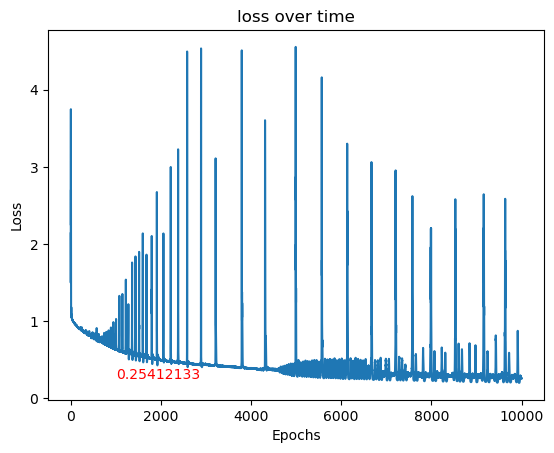

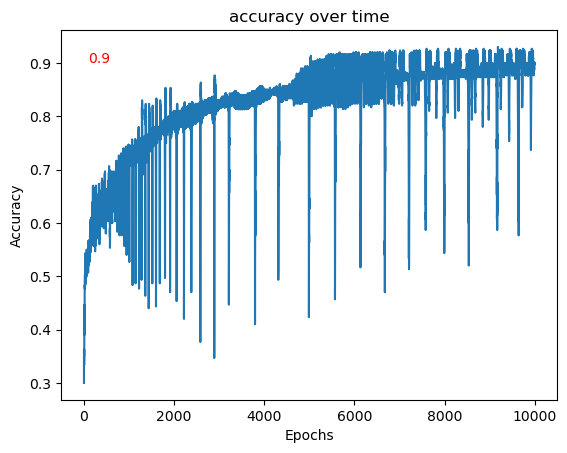

In [361]:
X, y = spiral_data(samples=100, classes=3)

dense1 = Layer_Dense(2, 64)
dense2 = Layer_Dense(64, 3)

activation1 = Activation_ReLU() 
loss_activation = Activation_Softmax_Loss_CategoricalCrossEntropy()

optimizer = Optimizer_GD()

loss_with_time = []
accuracy_with_time = []

for epoch in range(10001):
    # FORWARD PASS
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    loss = loss_activation.forward(dense2.output, y)

    # EVALUATE
    loss_with_time.append(loss) 
    accuracy_with_time.append(calculate_accuracy(loss_activation.output, y))
    # if(epoch % 100 == 0):
    #     print(f'epoch: {epoch}, accuracy: {calculate_accuracy(loss_activation.output, y): .3f}, loss: {loss: .3f}')

    # BACKWARD PASS
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # UPDATE PARAMETERS
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    

plt.annotate(loss_with_time[-1], (1000, loss_with_time[-1]), color='red')
plt.title(label="loss over time")
plt.plot(range(10001), loss_with_time)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.annotate(accuracy_with_time[-1], (100, accuracy_with_time[-1]), color='red')
plt.title(label="accuracy over time")
plt.plot(range(10001), accuracy_with_time)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

# A STAGNANT LOSS MEANS THE FUNCTION HAS FOUND IT'S LOCAL MINIMA

In [377]:
# Learning rate decay 
class Optimizer_LRD:
    # learning rate of 1 is default for this optimizer
    def __init__(self, learning_rate=1.0, decay=0.0):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay 
        self.iterations = 0

    # call once before any parameter updates 
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                                         (1 / (1 + self.decay * self.iterations))

    # update params
    def update_params(self, layer):
        layer.weights = layer.weights - self.current_learning_rate * layer.dweights
        layer.biases = layer.biases - self.current_learning_rate * layer.dbiases

    # call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1
        

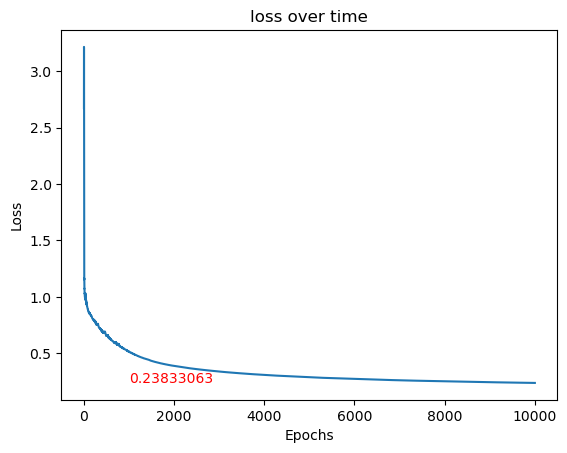

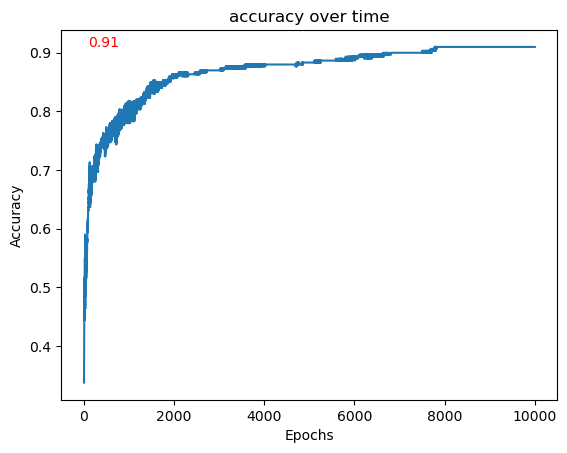

In [385]:
X, y = spiral_data(samples=100, classes=3)

dense1 = Layer_Dense(2, 64)
dense2 = Layer_Dense(64, 3)

activation1 = Activation_ReLU()
loss_activation = Activation_Softmax_Loss_CategoricalCrossEntropy() 

optimizer = Optimizer_LRD(decay=0.001)

loss_with_time = []
accuracy_with_time = []

for epoch in range(10001):
    # FORWARD PASS
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    loss = loss_activation.forward(dense2.output, y)

    # EVALUATE
    loss_with_time.append(loss) 
    accuracy_with_time.append(calculate_accuracy(loss_activation.output, y))

    # BACKWARD PASS 
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # UPDATE PARAMETERS
    optimizer.pre_update_params()
    optimizer.update_params(dense1) 
    optimizer.update_params(dense2)
    optimizer.post_update_params()
    

plt.annotate(loss_with_time[-1], (1000, loss_with_time[-1]), color='red')
plt.title(label="loss over time")
plt.plot(range(10001), loss_with_time)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.annotate(accuracy_with_time[-1], (100, accuracy_with_time[-1]), color='red')
plt.title(label="accuracy over time")
plt.plot(range(10001), accuracy_with_time)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

# THIS METHOD GIVES A LOT SMOOTHER CURVE

In [466]:
# Gradient Descent with Momentum 
class Optimizer_MomentumGD:
    def __init__(self, learning_rate=1., decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    def pre_update_params(self):
        self.current_learning_rate = self.learning_rate * (1 / (1 + self.decay * self.iterations))

    def update_params(self, layer):
        # if momentum is > 0.
        if(self.momentum):
            # if the layer has no momentum arrays, then create them
            if(not hasattr(layer, 'weight_momentums')):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)

            weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates

        # if no momentum, momentum = 0.
        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases

        # finally update the weights and biases
        layer.weights = layer.weights + weight_updates
        layer.biases = layer.biases + bias_updates

    def post_update_params(self):
        self.iterations += 1


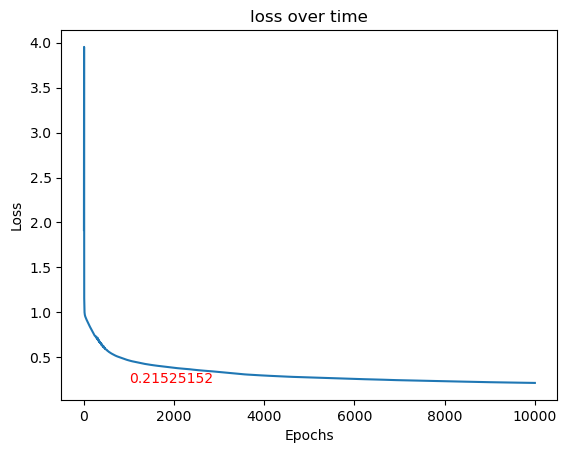

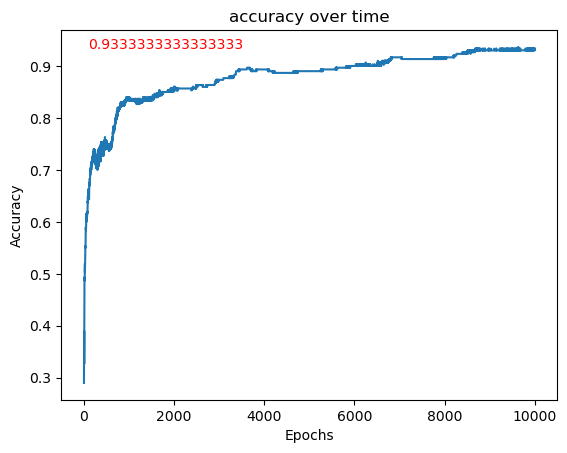

In [449]:
X, y = spiral_data(samples=100, classes=3)

dense1 = Layer_Dense(2, 64)
dense2 = Layer_Dense(64, 3)

activation1 = Activation_ReLU()
loss_activation = Activation_Softmax_Loss_CategoricalCrossEntropy()

optimizer = Optimizer_MomentumGD(decay=0.001, momentum=0.5)

loss_with_time = []
accuracy_with_time = []

for epoch in range(10001):
    # FORWARD PASS
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    loss = loss_activation.forward(dense2.output, y)

    # EVALUATE
    loss_with_time.append(loss)
    accuracy_with_time.append(calculate_accuracy(loss_activation.output, y))

    # BACKWARD PASS
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # UPDATE PARAMETERS
    optimizer.pre_update_params()
    optimizer.update_params(dense1) 
    optimizer.update_params(dense2)
    optimizer.post_update_params()

plt.annotate(loss_with_time[-1], (1000, loss_with_time[-1]), color='red')
plt.title(label="loss over time")
plt.plot(range(10001), loss_with_time)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.annotate(accuracy_with_time[-1], (100, accuracy_with_time[-1]), color='red')
plt.title(label="accuracy over time")
plt.plot(range(10001), accuracy_with_time)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


In [458]:
# AdaGrad - Adaptive Gradient
class Optimizer_AdaGrad:
    def __init__(self, learning_rate=1., decay=0., epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon

    def pre_update_params(self):
        if(self.decay):
            self.current_learning_rate = self.learning_rate / (1 + self.decay * self.iterations)

    def update_params(self, layer):
        if(not hasattr(layer, 'weight_cache')):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_cache += layer.dweights ** 2
        layer.bias_cache += layer.dbiases ** 2

        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)

    def post_update_params(self):
        self.iterations += 1
        

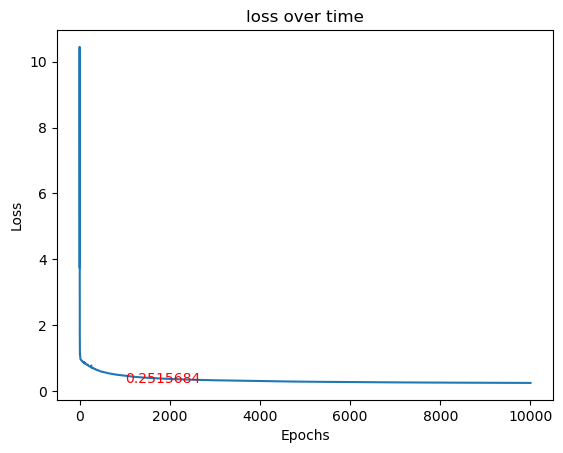

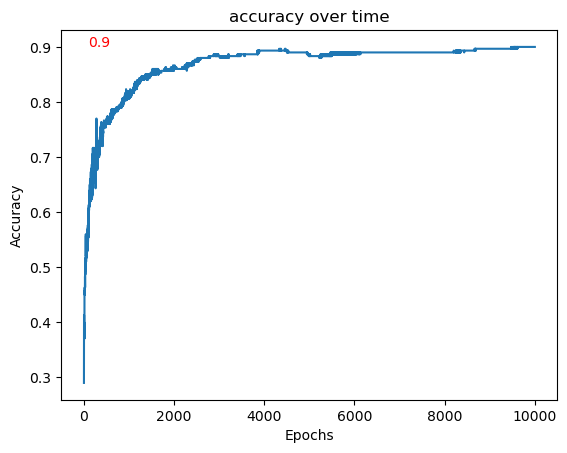

In [460]:
X, y = spiral_data(samples=100, classes=3)

dense1 = Layer_Dense(2, 64)
dense2 = Layer_Dense(64, 3)

activation1 = Activation_ReLU()
loss_activation = Activation_Softmax_Loss_CategoricalCrossEntropy()

optimizer = Optimizer_AdaGrad(decay=0.001)

loss_with_time = []
accuracy_with_time = []

for epoch in range(10001):
    # FORWARD PASS
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    loss = loss_activation.forward(dense2.output, y)

    # EVALUATE
    loss_with_time.append(loss)
    accuracy_with_time.append(calculate_accuracy(loss_activation.output, y))

    # BACKWARD PASS
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # UPDATE PARAMETERS
    optimizer.pre_update_params()
    optimizer.update_params(dense1) 
    optimizer.update_params(dense2)
    optimizer.post_update_params()

plt.annotate(loss_with_time[-1], (1000, loss_with_time[-1]), color='red')
plt.title(label="loss over time")
plt.plot(range(10001), loss_with_time)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.annotate(accuracy_with_time[-1], (100, accuracy_with_time[-1]), color='red')
plt.title(label="accuracy over time")
plt.plot(range(10001), accuracy_with_time)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()
    

In [498]:
# RMSprop optimizer 
# same as AdaGrad, but much more importance given to past(a) gradients

class Optimizer_RMSprop:
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho

    def pre_update_params(self):
        if(self.decay):
            self.current_learning_rate = self.learning_rate / (1 + self.decay * self.iterations)

    def update_params(self, layer):
        if(not hasattr(layer, 'weight_cache')):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_cache = self.rho * layer.weight_cache + (1 - self.rho) * layer.dweights**2
        layer.bias_cache = self.rho * layer.bias_cache + (1 - self.rho) * layer.dbiases**2

        layer.weights += -self.current_learning_rate * layer.dweights /  \
                          (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases /  \
                          (np.sqrt(layer.bias_cache) + self.epsilon)

    def post_update_params(self):
        self.iterations += 1
        

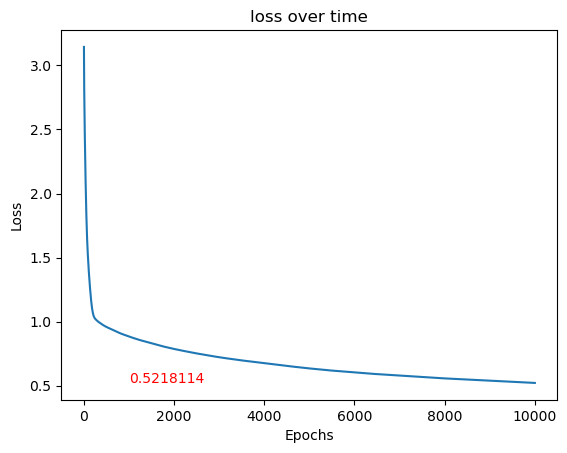

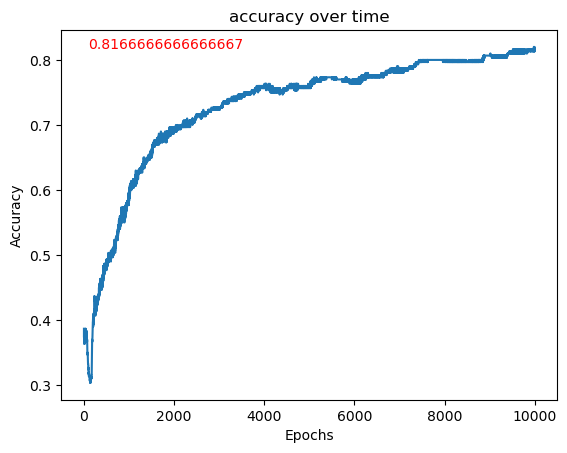

In [500]:
X, y = spiral_data(samples=100, classes=3)

dense1 = Layer_Dense(2, 64)
dense2 = Layer_Dense(64, 3)

activation1 = Activation_ReLU()
loss_activation = Activation_Softmax_Loss_CategoricalCrossEntropy()

optimizer = Optimizer_RMSprop(decay=0.001)

loss_with_time = []
accuracy_with_time = []

for epoch in range(10001):
    # FORWARD PASS
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    loss = loss_activation.forward(dense2.output, y)

    # EVALUATE
    loss_with_time.append(loss)
    accuracy_with_time.append(calculate_accuracy(loss_activation.output, y))

    # BACKWARD PASS
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # UPDATE PARAMETERS
    optimizer.pre_update_params()
    optimizer.update_params(dense1) 
    optimizer.update_params(dense2)
    optimizer.post_update_params()

plt.annotate(loss_with_time[-1], (1000, loss_with_time[-1]), color='red')
plt.title(label="loss over time")
plt.plot(range(10001), loss_with_time)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.annotate(accuracy_with_time[-1], (100, accuracy_with_time[-1]), color='red')
plt.title(label="accuracy over time")
plt.plot(range(10001), accuracy_with_time)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()
    

In [517]:
# Adam Optimizer (most important)
class Optimizer_Adam:
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    def pre_update_params(self):
        if(self.decay):
            self.current_learning_rate = self.learning_rate / (1 + self.decay * self.iterations)

    def update_params(self, layer):
        # create momentums and cache arrays if not present 
        if(not hasattr(layer, 'weight_momentums')):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        # update momentums with current gradients
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases

        # get corrected momentum
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

        # update caches with currect gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights ** 2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases ** 2

        # get corrected caches
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        # update the weights and biases
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / \
                          (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / \
                         (np.sqrt(bias_cache_corrected) + self.epsilon)
    
    def post_update_params(self):
        self.iterations += 1

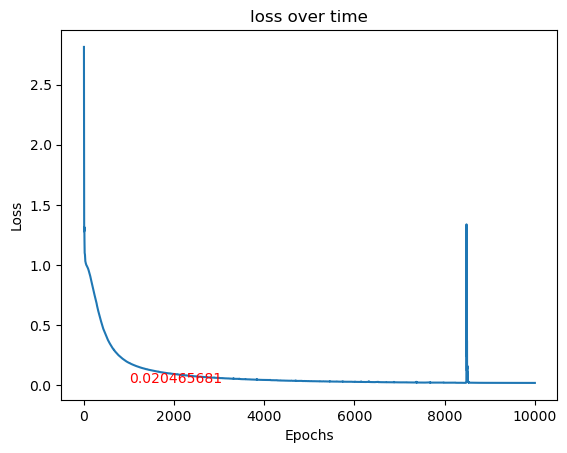

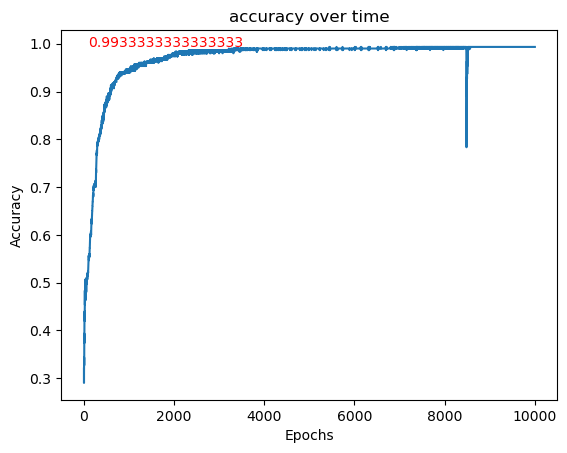

In [521]:
X, y = spiral_data(samples=100, classes=3)

dense1 = Layer_Dense(2, 64)
dense2 = Layer_Dense(64, 3)

activation1 = Activation_ReLU()
loss_activation = Activation_Softmax_Loss_CategoricalCrossEntropy()

optimizer = Optimizer_Adam(learning_rate=0.02)

loss_with_time = []
accuracy_with_time = []

for epoch in range(10001):
    # FORWARD PASS
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    loss = loss_activation.forward(dense2.output, y)

    # EVALUATE
    loss_with_time.append(loss)
    accuracy_with_time.append(calculate_accuracy(loss_activation.output, y))

    # BACKWARD PASS
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # UPDATE PARAMETERS
    optimizer.pre_update_params()
    optimizer.update_params(dense1) 
    optimizer.update_params(dense2)
    optimizer.post_update_params()

plt.annotate(loss_with_time[-1], (1000, loss_with_time[-1]), color='red')
plt.title(label="loss over time")
plt.plot(range(10001), loss_with_time)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.annotate(accuracy_with_time[-1], (100, accuracy_with_time[-1]), color='red')
plt.title(label="accuracy over time")
plt.plot(range(10001), accuracy_with_time)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

# HOLY SHEETS, CRAZY RESULTS!!!
# Note: the spikes indicate the overfitting in data

## Model Validation

In [540]:
X_test, y_test = spiral_data(samples=100, classes=3)

dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
loss = loss_activation.forward(dense2.output, y_test)

print("loss:", loss)
print("accuracy:", calculate_accuracy(loss_activation.output, y_test))

# bad accuracy and greater loss - we overfit the model on training data 💀

loss: 1.7425152
accuracy: 0.74


## Testing and Validation

In [545]:
# Testing dataset - to test our model on new, unseen data
# Validation data - to optimize hyperparameters of the neural network

## L1 and L2 Loss
### $ L_1 = \lambda \sum_i |p_i| $
### $ L_2 = \lambda \sum_i p_i^2 $
#### $ p = parameters (weights/ biases) $

## $ \frac{\partial L_1}{\partial p_i}[\lambda \sum_i |p_i|] = \lambda \begin{cases} 1, p_i > 1 \\ -1, p_i < 1 \\ \end{cases} $
## $ \frac{\partial L_2}{\partial p_i}[\lambda \sum_i p_i^2] = 2 \lambda p_i $

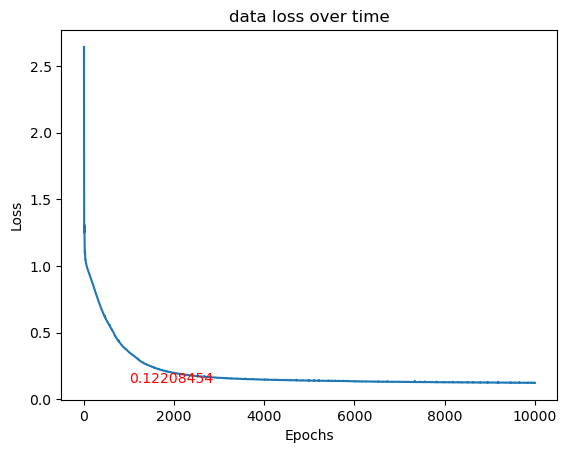

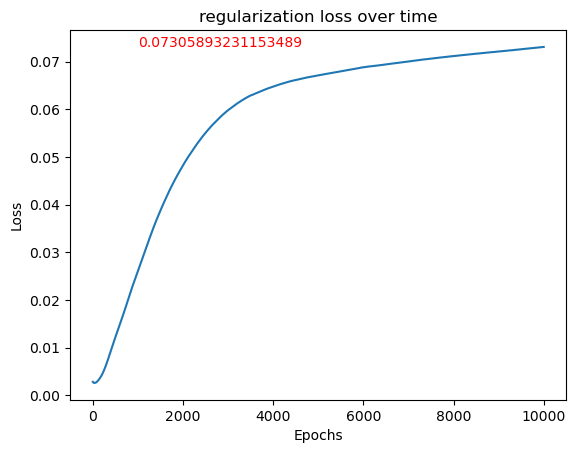

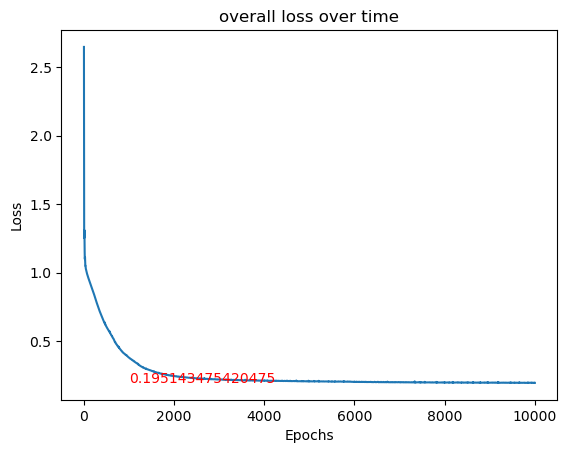

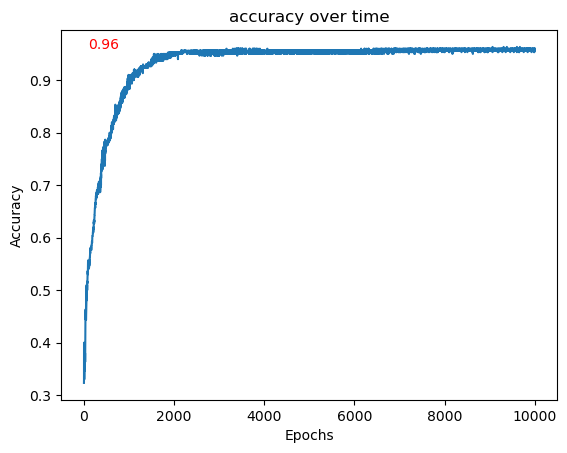

In [610]:
X, y = spiral_data(samples=100, classes=3)

dense1 = Layer_Dense(2, 64, weight_regularizer_l2=1e-5, bias_regularizer_l2=1e-5)
dense2 = Layer_Dense(64, 3, weight_regularizer_l2=1e-5, bias_regularizer_l2=1e-5)

activation1 = Activation_ReLU()
loss_activation = Activation_Softmax_Loss_CategoricalCrossEntropy()

optimizer = Optimizer_Adam(learning_rate=0.02)

data_loss_with_time = []
regularization_loss_with_time = []
overall_loss_with_time = []
accuracy_with_time = []

for epoch in range(10001):
    # FORWARD PASS
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    data_loss = loss_activation.forward(dense2.output, y)

    regularization_loss = loss_activation.loss.regularization_loss(dense1) + \
                          loss_activation.loss.regularization_loss(dense2)

    overall_loss = data_loss + regularization_loss

    # EVALUATE
    data_loss_with_time.append(data_loss)
    regularization_loss_with_time.append(regularization_loss)
    overall_loss_with_time.append(overall_loss)
    accuracy_with_time.append(calculate_accuracy(loss_activation.output, y))

    # BACKWARD PASS
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # UPDATE PARAMETERS
    optimizer.pre_update_params()
    optimizer.update_params(dense1) 
    optimizer.update_params(dense2)
    optimizer.post_update_params()

plt.annotate(data_loss_with_time[-1], (1000, data_loss_with_time[-1]), color='red')
plt.title(label="data loss over time")
plt.plot(range(10001), data_loss_with_time)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.annotate(regularization_loss_with_time[-1], (1000, regularization_loss_with_time[-1]), color='red')
plt.title(label="regularization loss over time")
plt.plot(range(10001), regularization_loss_with_time)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.annotate(overall_loss_with_time[-1], (1000, overall_loss_with_time[-1]), color='red')
plt.title(label="overall loss over time")
plt.plot(range(10001), overall_loss_with_time)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.annotate(accuracy_with_time[-1], (100, accuracy_with_time[-1]), color='red')
plt.title(label="accuracy over time")
plt.plot(range(10001), accuracy_with_time)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


### Let's test our new Model

In [666]:
X_test, y_test = spiral_data(samples=100, classes=3)

dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
loss = loss_activation.forward(dense2.output, y_test)

print("validation")
print("loss:", loss)
print("accuracy:", calculate_accuracy(loss_activation.output, y_test))

# much better loss and accuracy (but still not great though)
# to improve the loss and accuracy further more, use a larger dataset

validation
loss: 0.77687573
accuracy: 0.8366666666666667


## Introducing Dropout Layers
#### Dropout Layers essentially just "switch off" some of the neurons to avoid overfitting to training data

In [683]:
class Layer_Dropout:
    def __init__(self, dropout_rate):
        # self.rate = success rate (how many neurons to keep)
        self.rate = 1 - dropout_rate

    def forward(self, inputs):
        self.inputs = inputs
        self.binary_mask = np.random.binomial(1, self.rate, size=inputs.shape) / self.rate
        self.output = self.inputs * self.binary_mask

    def backward(self, dvalues):
        self.dinputs = dvalues * self.binary_mask
        

## New Model with Dropout Layers

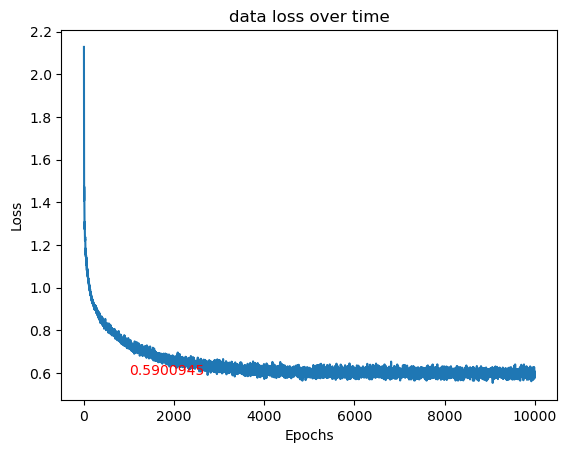

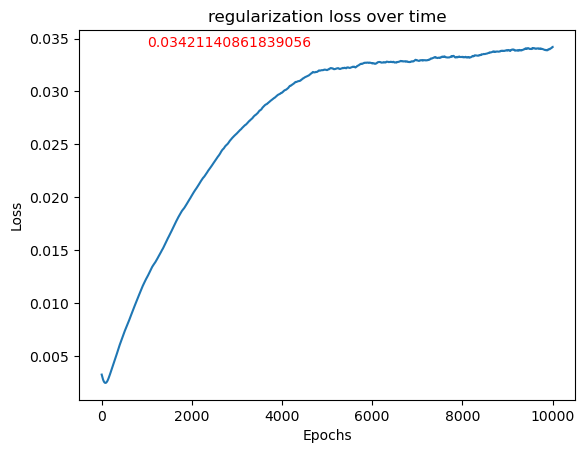

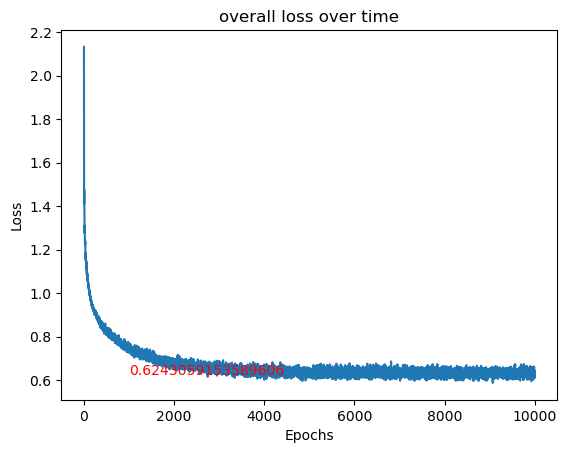

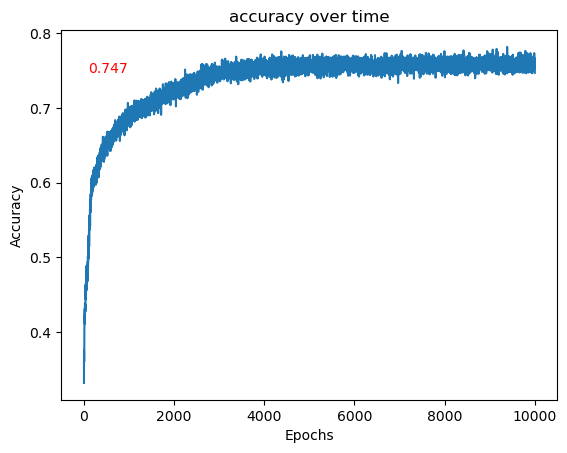

In [691]:
X, y = spiral_data(samples=1000, classes=3)

dense1 = Layer_Dense(2, 64, weight_regularizer_l2=1e-5, bias_regularizer_l2=1e-5)
dense2 = Layer_Dense(64, 3, weight_regularizer_l2=1e-5, bias_regularizer_l2=1e-5)

dropout1 = Layer_Dropout(0.1)

# dropout in the last layer is not needed as it is the output layer
# dropout2 = Layer_Dropout(0.2)

activation1 = Activation_ReLU()
loss_activation = Activation_Softmax_Loss_CategoricalCrossEntropy()

optimizer = Optimizer_Adam(learning_rate=0.02)

data_loss_with_time = []
regularization_loss_with_time = []
overall_loss_with_time = []
accuracy_with_time = []

for epoch in range(10001):
    # FORWARD PASS
    dense1.forward(X)
    activation1.forward(dense1.output)
    dropout1.forward(activation1.output)
    dense2.forward(dropout1.output)
    data_loss = loss_activation.forward(dense2.output, y)

    regularization_loss = loss_activation.loss.regularization_loss(dense1) + \
                          loss_activation.loss.regularization_loss(dense2)

    overall_loss = data_loss + regularization_loss

    # EVALUATE
    data_loss_with_time.append(data_loss)
    regularization_loss_with_time.append(regularization_loss)
    overall_loss_with_time.append(overall_loss)
    accuracy_with_time.append(calculate_accuracy(loss_activation.output, y))

    # BACKWARD PASS
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    dropout1.backward(dense2.dinputs)
    activation1.backward(dropout1.dinputs)
    dense1.backward(activation1.dinputs)

    # UPDATE PARAMETERS
    optimizer.pre_update_params()
    optimizer.update_params(dense1) 
    optimizer.update_params(dense2)
    optimizer.post_update_params()

plt.annotate(data_loss_with_time[-1], (1000, data_loss_with_time[-1]), color='red')
plt.title(label="data loss over time")
plt.plot(range(10001), data_loss_with_time)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.annotate(regularization_loss_with_time[-1], (1000, regularization_loss_with_time[-1]), color='red')
plt.title(label="regularization loss over time")
plt.plot(range(10001), regularization_loss_with_time)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.annotate(overall_loss_with_time[-1], (1000, overall_loss_with_time[-1]), color='red')
plt.title(label="overall loss over time")
plt.plot(range(10001), overall_loss_with_time)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.annotate(accuracy_with_time[-1], (100, accuracy_with_time[-1]), color='red')
plt.title(label="accuracy over time")
plt.plot(range(10001), accuracy_with_time)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

# DO NOT RUN THIS CELL AGAIN ☠️ (TOOK ~200 Sec TO TRAIN)

### Let's test the new model 

In [705]:
X_test, y_test = spiral_data(samples=100, classes=3)

dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
loss = loss_activation.forward(dense2.output, y_test)

print("validation")
print("loss:", loss)
print("accuracy:", calculate_accuracy(loss_activation.output, y_test))

# Much Better Loss, though accuracy is low

validation
loss: 0.5253471
accuracy: 0.79
